# Mini Gato

Goals:

- Simplicity
- Minimal dependencies
- Clear explanations
- Quickly iterable executable examples
- Extensible architecture

Non-goals:

- Performance
- Eval metrics

If I succeed at the goals then I expect the path towards the non-goals will be clear.

# What is Gato?

A transformer trained on a wide variety of data, including diverse modalities such as images, text, proprioception, joint torques, button presses, and other discrete and continuous observations and actions. [[§2](https://arxiv.org/pdf/2205.06175#page=3)]

**How does it work?**

It serializes all data into a flat sequence of tokens. In this representation, Gato can be trained and sampled from akin to a standard large-scale language model. [[§ 2](https://arxiv.org/pdf/2205.06175#page=3)]

Note: Gato is _not_ a new _model architecture_. It's a way of tokenizing, embedding, and sequencing data from multiple diverse modalities so that the data can be used in existing transformer architectures.

## Tokenization [§ 2.1](https://arxiv.org/pdf/2205.06175#page=3)

There are infinite possible ways to transform data into tokens, including directly using the raw underlying byte stream. Below is what the Gato paper found to produce the best results using contemporary (2022) hardware and model architecture.

- Text is encoded via SentencePiece. \[I expect the choice of text encoder doesn't make a huge difference. I'll probably be using the GPT2 encoder in this notebook.
- Images are first transformed into sequences of non-overlapping 16x16 patches in raster order, as done in [ViT (Dosovitskiy et al., 2020)](https://arxiv.org/pdf/2010.11929).
- Discrete values, e.g. Atari button presses, are flattened into sequences of integers (within the range [0, 1024).
- Continuous values, e.g. proprioceptive inputs or join torques, are first flattened into sequences of floating point values, then mu-law encoded to the range [-1, 1], then discretized into 1024 uniform bins.
- The final discrete values are then shifted to the range after the tail end of the text encoder vocabulary (in the case of SentencePiece, [32000, 33024).

## Sequence Ordering [§ 2.1](https://arxiv.org/pdf/2205.06175#page=3)

After converting data into tokens, we use the following canonical sequence ordering.

- Text tokens in the same order as the raw input text.
- Image patch tokens in raster order.
- Nested structures in lexicographical order by key.
- Agent timesteps as observation tokens followed by a separator, then action tokens.
- Agent episodes as timesteps in time order.

# Text

To accomplish our goals, we need a small dataset with samples that are easy to understand. I want it to be obvious how well things are working when we run quick sanity checks.

**[Shakespear](https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt)**

There's enough data to usefully train, it's small enough to download and prepare quickly, and it will be easy to do a sanity-check human-eval on the output to know how good we're doing.

To accomplish the goal of minimal dependencies and clear explanations, we'll grab the dataset in its raw format. We _could_ get the same dataset from a model hub, like HuggingFace. But this is a perfect time to demonstrate how you would turn raw data into a useful dataset.

In the [words of Karpathy](https://karpathy.github.io/2019/04/25/recipe/#1-become-one-with-the-data):

> Become one with the data.

Take a look at the [raw data](https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt) so you know what we're working with.

The raw data is just 40,000 lines in a single text file.

> ANTONIO:
> We two, my lord,
> Will guard your person while you take your rest,
> And watch your safety.
> 
> ALONSO:
> Thank you. Wondrous heavy.
> 
> SEBASTIAN:
> What a strange drowsiness possesses them!
> 
> ANTONIO:
> It is the quality o' the climate.
> 
> SEBASTIAN:
> Why
> Doth it not then our eyelids sink? I find not
> Myself disposed to sleep.

Each character's lines are separated by an empty line.

Here, we face a common question.

**How do we transform this data into samples that can be input to a model?**

You'll face this question with almost every raw dataset that you prepare. There's no _right_ answer. You could treat [every 3 characters as a sample](https://youtu.be/TCH_1BHY58I?t=587) (a tri-gram model). You could split on paragraph (or in the case of a Shakespeare play, a scene). Or anything else. The only constraint is your samples are small enough to fit the input dimensions (a.k.a the sequence length or the context length) of your model.

We want our training data to have a long enough context to learn from entire conversations of multiple characters. So, we don't want our DataLoader to return samples of 1 character speaking. That would be too short.

I suggest we split on each character's lines and then take a number of character's lines in sequence until we have more than ~250 words. That ought to play nicely with a sequence length of ~512 or ~1024 or whatever we decide. If we want to play with smaller sequence lengths, we can always truncate. (And larger sequence lengths we'll just pad.)

In [1]:
import os
from pathlib import Path
import re
import tempfile
import requests

def acquire_shakespeare_dataset():
    temp_dir = tempfile.gettempdir()
    shakespeare_filepath = Path(temp_dir)/"shakespeare.txt"
    if not os.path.exists(shakespeare_filepath):
        data_url = 'https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt'
        with open(shakespeare_filepath, 'w', encoding='utf-8') as f:
            f.write(requests.get(data_url).text)
    
    with open(shakespeare_filepath, 'r', encoding='utf-8') as f:
        data = f.read()

    # Split the dataset into each character's lines.
    # Continue taking lines until you have at least 250 words in the sample.
    # Add that sample to the dataset.
    characters_lines = re.split(r"\n\s*\n", data.strip())
    MIN_WORDS_PER_BATCH = 250
    sample = [characters_lines[0]]
    num_words_in_sample = len(characters_lines[0].split())
    text_dataset = []
    i = 1
    while i < len(characters_lines):
        if num_words_in_sample > MIN_WORDS_PER_BATCH:
            text_dataset.append("\n\n".join(sample))
            num_words_in_sample -= len(sample[0].split())
            sample = sample[1:]
        sample += [characters_lines[i]]
        num_words_in_sample += len(characters_lines[i].split())
        i += 1

    return text_dataset

In [2]:
text_dataset = acquire_shakespeare_dataset()

In [3]:
print(f"Number of samples in the dataset: {len(text_dataset)}")
print(f"Character length of first 3 samples: {[len(x) for x in text_dataset[:3]]}\n")
print(f"First 80 characters of first sample:\n\n{text_dataset[0][:80]}")

Number of samples in the dataset: 7184
Character length of first 3 samples: [1632, 1688, 1891]

First 80 characters of first sample:

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.


## Tokenize text

> There are infinite possible ways to transform data into tokens, including directly using the raw underlying byte stream. Below we report the tokenization scheme we found to produce the best results for Gato at the current scale using contemporary hardware and model architectures.
> Text is encoded via SentencePiece (Kudo & Richardson, 2018) with 32000 subwords into the integer range [0, 32000).
> ...

For this example, we'll use GPT2. The only thing to note as you change tokenizers is that discrete/continuous values get tokenized to the 1024 numbers after the vocab size (32000 to 33024 in the case of SentencePiece). So, you'll need to make that update as you change tokenizers.

GPT2 has a vocab size of 50256, so our discrete/continuous values will tokenize to the range 50256 to 51280.

In [4]:
import torch
from transformers import GPT2Tokenizer

In [5]:
# Prefixing with _ to signify global.
_text_tokenizer = GPT2Tokenizer.from_pretrained("openai-community/gpt2", clean_up_tokenization_spaces=True)
_text_tokenizer.pad_token = _text_tokenizer.eos_token
tokenize_text = _text_tokenizer

### Context length

All modalities must share the same context length. We'll have to decide what that is now, since we're starting on our first modality, text.

Text is easy, because the text we train on will usually have a lot more than 1024 tokens of context, and truncating won't affect the quality of the context.

But when we get to things like videos/images/robotics, it might be hard to fit a single "episode" into a small context. Each image of a video might take up hundreds of tokens, leaving us room for only 2 or 3 images in a single training example (with the remaining tokens taken up by other forms of observation, like proprioception input).

I'll arbitrarily pick 1024 as a context window for now.

In [6]:
SEQUENCE_LENGTH = 1024
BATCH_SIZE=3

In [7]:
text_batch = tokenize_text(text_dataset[:BATCH_SIZE], max_length=SEQUENCE_LENGTH, truncation=True, padding="max_length", return_tensors="pt")
text_batch["input_ids"].shape, text_batch["attention_mask"].shape

(torch.Size([3, 1024]), torch.Size([3, 1024]))

## Embed text

What size should our embedding dimension be?

We could almost pick any arbitrary number here. Karpathy has [a reference in his minGPT repo that says GPT2 used 768 dimensions](https://github.com/karpathy/minGPT/blob/37baab71b9abea1b76ab957409a1cc2fbfba8a26/mingpt/model.py#L131).

Pick too large of a number and you'll run into resource bottlenecks. I tried with 768 dimensions and it seemed to be a bit too much for my machine.

W're actually a bit constricted in our choices. We can't choose any arbitrary number. We're restricted by requirements of the image modality. How are we going to embed _images_? We're going to split the image into a grid of $n$ by $m$ patches (each with 3 color channels). Therefore, our embedding needs to be $3 * n * m$. 12 by 12 seemed to be a sweet spot in my experiments. So, 432 dimensions.

In [8]:
import torch.nn as nn

In [9]:
EMBEDDING_DIM = 432

In [10]:
_text_embedding = nn.Embedding(_text_tokenizer.vocab_size, EMBEDDING_DIM)
embed_text = _text_embedding

## Sequence text

"Sequencing" our data samples is going to be the hardest part of Gato.

It's really simple for text. You just input the words into the model in the order that they appear in the text.

But what sequence would you use for a robot task, where there's a single text description of the objective, a sequence of images, and a sequence of proprioceptions?

Because it's going to get so complex for later modalities, expect to see more interesting "Sequence text" headings in the future.

In [11]:
def sequence_text(tokenizer, embedder, max_length, batch):
    tokens = tokenizer(batch, max_length=max_length+1, padding="max_length", truncation=True, return_tensors="pt")
    ys = tokens["input_ids"].clone()[:, 1:]
    embedding = embedder(tokens["input_ids"][:, :-1])
    return embedding, ys, tokens["attention_mask"][:, :-1]

In [12]:
from torch.utils.data import DataLoader, Dataset
from functools import partial

In [13]:
_text_tokenizer(next(iter(DataLoader(text_dataset, batch_size=BATCH_SIZE))));

## Text DataLoader

**TODO**: *Bad design? DataLoading can be parallelized on CPU. Embeddings will need to be on the GPU. What are the consequences?*

Above, we wrote all of our utilities for tokenizing, embedding, and sequencing text.

How do we combine all of those utilities?

Honestly, it doesn't much matter _how_ you combine them. The important thing is that the model gets:

1. input embeddings
2. output target
3. mask

The reason it's so important that the model get the embeddings (rather than input at some stage pre-embedding) is that:

- the Gato architecture has many complexities in how it sequences different modalities
- datasets have wild variations in their structure and data types

If you try to deal with data _inside_ the Gato model, then you're left with a tangled mess of conditionals.

If you enforce a standard at the input boundary, then the code to wrangle each dataset is isolated in it's own tinly little tangled mess which doesn't affect the rest of the datasets or the model.

The only "gotcha" to remember about this: your embedding dimensions won't be part of an `nn.Module`. You'll have to remember to tell your optimizer about them.

In [14]:
text_dataloader = map(
    partial(sequence_text, tokenize_text, _text_embedding, SEQUENCE_LENGTH),
    DataLoader(text_dataset, batch_size=BATCH_SIZE)
)
text_xs, text_ys, text_mask = next(iter(text_dataloader))

In [15]:
text_xs.shape, text_ys.shape, text_mask.shape

(torch.Size([3, 1024, 432]), torch.Size([3, 1024]), torch.Size([3, 1024]))

# VQA

Unlike text, it's hard to get a small and simple dataset for visual question answering.

The [OK-VQA dataset](https://okvqa.allenai.org/index.html) has 14,055 `(image, question, answer)` tuples (along with some other data, like a confidence rating in the answer, and multiple answers where the question is ambiguous).

That's not _huge_. But it's kind of nice to be able to really quickly _overfit_ when you're first experimenting with these models. Pursposefully overfitting is a good sanity check. If you can't overfit, then you _definitely_ can't _fit_...

So, let's use something smaller than [OK-VQA](https://okvqa.allenai.org/index.html).

Let's use [eihli/micro-ok-vqa](https://huggingface.co/datasets/eihli/micro-ok-vqa), and see if we can overfit. It's just the first 100 images from OK-VQA. 80 train, 20 validation.

In [16]:
import random
import datasets
import torchvision.transforms.v2 as transforms

In [17]:
vqa_dataset = datasets.load_dataset("eihli/micro-ok-vqa").with_format("pt")

Once again, in the [words of Karpathy](https://karpathy.github.io/2019/04/25/recipe/#1-become-one-with-the-data):

> Become one with the data.

In [18]:
vqa_dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'question_type', 'confidence', 'answers', 'image_id', 'answer_type', 'question_id', 'question'],
        num_rows: 80
    })
    validation: Dataset({
        features: ['image', 'question_type', 'confidence', 'answers', 'image_id', 'answer_type', 'question_id', 'question'],
        num_rows: 20
    })
})

In [19]:
vqa_dataset["train"]

Dataset({
    features: ['image', 'question_type', 'confidence', 'answers', 'image_id', 'answer_type', 'question_id', 'question'],
    num_rows: 80
})

In [20]:
vqa_dataset['train']['image'][0].shape

torch.Size([3, 479, 640])

In [21]:
vqa_dataset["train"]["question"][:5]

['What is the hairstyle of the blond called?',
 'How old do you have to be in canada to do this?',
 'Can you guess the place where the man is playing?',
 'Which rail company is named after a town in new mexico?',
 'Is the boy swimming or doing another water activity?']

In [22]:
len(vqa_dataset["train"]["answers"][0]), vqa_dataset["train"]["answers"][0][:3]

(10,
 [{'answer': 'pony tail',
   'raw_answer': 'pony tail',
   'answer_confidence': 'yes',
   'answer_id': tensor(1)},
  {'answer': 'pony tail',
   'raw_answer': 'pony tail',
   'answer_confidence': 'yes',
   'answer_id': tensor(2)},
  {'answer': 'pony tail',
   'raw_answer': 'pony tail',
   'answer_confidence': 'yes',
   'answer_id': tensor(3)}])

This is the kind of one-off work you'll encounter for each dataset.

This particular VQA dataset offers 10 possible answers for each question. I assume the idea is that some image questions are ambiguous.

Part of our work is deciding how we want to handle that.

In the grand scheme of this model, I don't think there's a reasonable decision we could make here that would result in a significant change to the model quality.

My plan is to just randomly select an answer and ignore the "answer_confidence" value.

In [23]:
micro_ok_vqa_transform = transforms.Compose([
    # No particular reason to use `transforms.Compose` here since we're only doing one transform. But it's nice to know about.
    transforms.RandomResizedCrop((192, 192), (0.5, 1.0)),
])

In [24]:
def micro_ok_vqa_collate_fn(batch):
    answers = [random.choice(el["answers"])["answer"] for el in batch]
    questions = [el["question"] for el in batch]
    images = torch.stack([micro_ok_vqa_transform(el["image"]) for el in batch])
    return {
        "question": questions,
        "image": images,
        "answer": answers,
    }

In [25]:
vqa_dl = DataLoader(vqa_dataset["train"], batch_size=8, collate_fn=micro_ok_vqa_collate_fn)
vqa_batch = next(iter(vqa_dl))

In [26]:
vqa_batch["image"].shape

torch.Size([8, 3, 192, 192])

In [27]:
import matplotlib.pyplot as plt

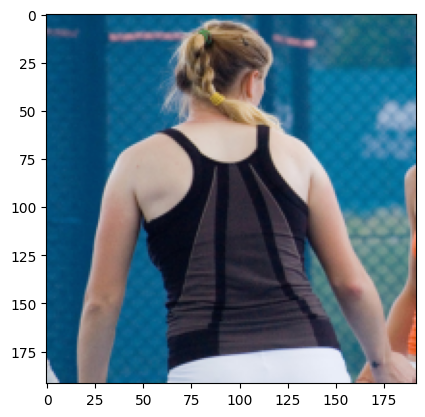

In [28]:
plt.imshow(vqa_batch["image"][0].permute(1, 2, 0))

### Tokenizing images

Sweet.

Now.

How do we tokenize images?

> Images are first transformed into sequences of non-overlapping 16 × 16 patches in raster order, as done in ViT (Dosovitskiy et al., 2020). Each pixel in the image patches is then normalized between [−1, 1] and divided by the square-root of the patch size (i.e. √16 = 4).

We'll use 12 by 12 to keep our model a bit smaller and faster.

Note that even though we're encoding text (the question and answer), we can't simply re-use the `tokenize_text` function that we used previously, because that function assumed the text was taking up the entire context window. The question and answer will only take up a small portion of the context window in the VQA case. The image will take up a large portion.

In [29]:
images = vqa_batch["image"]
images.shape

torch.Size([8, 3, 192, 192])

In [30]:
from einops import rearrange

In [31]:
patch_size=12

In [32]:
patches = rearrange(images, 'b c (h s1) (w s2) -> b (h w) (s1 s2 c)', s1=patch_size, s2=patch_size)
patches.shape

torch.Size([8, 256, 432])

In [33]:
patches_matplotlib_dims = rearrange(images, 'b c (h s1) (w s2) -> b (h w) s1 s2 c', s1=patch_size, s2=patch_size)
patches.shape

torch.Size([8, 256, 432])

### Image Patches

16x16 grid of 12x12 pixel patches.

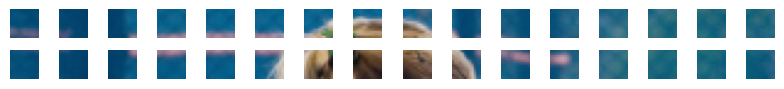

In [34]:
fig, axes = plt.subplots(nrows=2, ncols=16, figsize=(8, 1))

for i in range(2):
    for j in range(16):
        axes[i, j].imshow(patches_matplotlib_dims[0][i * 16 + j])
        axes[i, j].axis("off")
plt.tight_layout()
plt.show()

In [35]:
reconstructed = rearrange(patches, 'b (ph pw) (sh sw c) -> b c (ph sh) (pw sw)', ph=16, pw=16, sh=patch_size, sw=patch_size)
reconstructed.shape

torch.Size([8, 3, 192, 192])

In [36]:
(reconstructed == images).all()

tensor(True)

In [37]:
def images_to_patches(images, patch_size=12):
    return rearrange(images, 'b c (h s1) (w s2) -> b (h w) (c s1 s2)', s1=patch_size, s2=patch_size)

# We don't need this as part of Gato. It's just here to play with and visually test the code.
def patches_to_image(patches, image_shape, patch_size=12):
    channels, height, width = image_shape
    patch_height = height // patch_size
    patch_width = width // patch_size
    reconstructed = rearrange(
        patches, 
        'b (ph pw) (c ps1 ps2) -> b c (ph ps1) (pw ps2)',
        ph=patch_height,
        pw=patch_width,
        ps1=patch_size,
        ps2=patch_size,
    )
    return reconstructed

In [38]:
# And to prove that we can go from image -> patch -> image
recovered_images = patches_to_image(images_to_patches(images), (3, 192, 192))
(recovered_images == images).all()

tensor(True)

Other than patching, is there anything else?

> Each pixel in the image patches is then normalized between [−1, 1] and divided by the square-root of the patch size (i.e. √16 = 4).

How do we normalize?

How do we normalize along the _patch_ dimension?

Let's first handle normalizing a rank one tensor. Then, we'll write a helper utility to apply that kind of function across any arbitrary dimension.

In [39]:
def normalize_to_between_minus_one_plus_one(t: torch.Tensor):
    min_val, max_val = t.min(), t.max()
    if min_val == max_val:
        return torch.zeros_like(t)
    normalized = 2 * (t - min_val) / (max_val - min_val) - 1
    return normalized

In [40]:
normalize_to_between_minus_one_plus_one(torch.arange(6))

tensor([-1.0000, -0.6000, -0.2000,  0.2000,  0.6000,  1.0000])

In [41]:
# There's a small deviation in the NEKO codebase from the paper.
# The paper normalizes _per patch_. The NEKO codebase currently normalizes _per image_.
# https://github.com/eihli/NEKO/blob/master/gato/policy/embeddings.py#L38
# This notebook normalizeds per patch. That's what this utility helps.
def apply_along_dimension(func, dim, tensor):
    tensor = tensor.transpose(0, dim)
    shape = tensor.shape
    tensor = tensor.reshape(shape[0], -1)
    result = torch.stack([func(tensor[:, i]) for i in range(tensor.size(1))], dim=1)
    result = result.reshape(shape).transpose(0, dim)
    return result

And here's a simple sanity check. I'll pick some data that's simple to reason about and I'll pick some operations that will highlight the effects of the code.

In [42]:
example = torch.arange(12).view(3, 2, 2)
print(f"starting tensor:\n{example}\n")
print(f"t * t.min() along dim 0:\n{apply_along_dimension(lambda t: t * t.min(), 0, example)}\n")
print(f"t * t.min() along dim 1:\n{apply_along_dimension(lambda t: t * t.min(), 1, example)}\n")
print(f"t * t.min() along dim 2:\n{apply_along_dimension(lambda t: t * t.min(), 2, example)}\n")

starting tensor:
tensor([[[ 0,  1],
         [ 2,  3]],

        [[ 4,  5],
         [ 6,  7]],

        [[ 8,  9],
         [10, 11]]])

t * t.min() along dim 0:
tensor([[[ 0,  1],
         [ 4,  9]],

        [[ 0,  5],
         [12, 21]],

        [[ 0,  9],
         [20, 33]]])

t * t.min() along dim 1:
tensor([[[ 0,  1],
         [ 0,  3]],

        [[16, 25],
         [24, 35]],

        [[64, 81],
         [80, 99]]])

t * t.min() along dim 2:
tensor([[[  0,   0],
         [  4,   6]],

        [[ 16,  20],
         [ 36,  42]],

        [[ 64,  72],
         [100, 110]]])



In [43]:
def tokenize_image(image: torch.Tensor) -> torch.Tensor:
    """Convert images to patches, normalize each patch, then prepare it for
    embedding by reshaping to CxHxW so that we can send it through the conv
    layers of a ResNet block.
    """ 
    image = images_to_patches(image)
    # Hardcoding as a reminder to do something smarter
    SQUARE_ROOT_OF_PATCH_SIZE = 3.464
    image = (
        apply_along_dimension(
            normalize_to_between_minus_one_plus_one, 2, image
        )
        / SQUARE_ROOT_OF_PATCH_SIZE
    )
    return image

In [44]:
vqa_batch["image_tokens"] = tokenize_image(vqa_batch["image"])

In [45]:
vqa_batch["image_tokens"].shape

torch.Size([8, 256, 432])

### Image Embedding

> 2.2 Embedding input tokens and setting output targets
> 
> After tokenization and sequencing, we apply a parameterized embedding function f (·; θe) to each token (i.e. it is applied to both observations and actions) to produce the final model input. To enable efficient learning from our multi-modal input sequence s1:L the embedding function performs different operations depending on the modality the token stems from...
> 
> Tokens belonging to image patches for any time-step are embedded using a single ResNet (He et al., 2016a) block to obtain a vector per patch. For image patch token embeddings, we also add a learnable within-image position encoding vector.

A single ResNet block. Ok. Easy.

In [46]:
import torch.nn as nn

In [47]:
# From section 2.2 of the Gato paper:
#
#    Tokens belonging to image patches for any time-step are embedded using a
#    single ResNet (He et al., 2016a) block to obtain a vector per patch. For
#    image patch token embeddings, we also add a learnable within-image position
#    encoding vector.
class ResNetV2Block(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, num_groups=24):
        super(ResNetV2Block, self).__init__()
        self.gn1 = nn.GroupNorm(1, in_channels)
        self.gelu = nn.GELU()
        self.conv1 = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False,
        )
        self.gn2 = nn.GroupNorm(num_groups, out_channels)
        self.conv2 = nn.Conv2d(
            out_channels, in_channels, kernel_size=3, stride=1, padding=1, bias=False
        )

    def forward(self, x):
        B, T, CHW = x.shape
        # TODO: Remove these hardcoded values.
        out = rearrange(x, 'b t (c h w) -> (b t) c h w', c=3, h=16)
        out = self.gn1(out)
        out = self.gelu(out)
        out = self.conv1(out)
        out = self.gn2(out)
        out = self.gelu(out)
        out = self.conv2(out)
        return x + rearrange(out, '(b t) c h w -> b t (c h w)', b=B, t=T)

_image_embedding = ResNetV2Block(3, EMBEDDING_DIM)
# This _position_embedding doesn't match exactly what's in the Gato paper.
# The gato/policy/embeddings.py file has the exact implementation from the paper.
# https://github.com/eihli/NEKO/blob/explore-simplify-dataset-dataloader/gato/policy/embeddings.py#L91

> **Patch Position Encodings**
> 
> These position encodings convey information about a patch’s global position within the image from which the patch was extracted. First, the relative row and column intervals of the patch are calculated by normalizing the patch’s pixel intervals by the image resolution. The row and column normalized intervals are then quantized into a vocabulary size (we use 128) and are used to index a row and column table of learnable position encodings. The method in which the quantized row and column intervals are converted into indices depends on whether we are training or evaluating the model: during training a random index is uniformly sampled from the quantized interval, while during evaluation we deterministically take the (rounded) mean of the interval. Once row and column position encoding are retrieved from the embedding table, they are added onto the token embedding produced by the resnet embedding function, as described previously.

> ...First, the relative row and column intervals of the patch are calculated by normalizing the patch’s pixel intervals by the image resolution...
> 
> ...The row and column normalized intervals are then quantized into a vocabulary size (we use 128) and are used to index a row and column table of learnable position encodings...

In [48]:
patches = images_to_patches(images)
patches.shape

torch.Size([8, 256, 432])

In [49]:
def heights_widths(images): return tuple(map(torch.tensor, zip(*[image.shape[1:3] for image in images])))

In [50]:
heights_widths(vqa_batch["image"])

(tensor([192, 192, 192, 192, 192, 192, 192, 192]),
 tensor([192, 192, 192, 192, 192, 192, 192, 192]))

In [51]:
heights, widths = map(torch.tensor, zip(*[img.shape[1:3] for img in vqa_batch["image"][0:8]]))
heights, widths

(tensor([192, 192, 192, 192, 192, 192, 192, 192]),
 tensor([192, 192, 192, 192, 192, 192, 192, 192]))

In [52]:
vqa_batch["image"].shape

torch.Size([8, 3, 192, 192])

In [53]:
def intervals(n_patch_rows, n_patch_cols):
    """Returns [row_interval, col_interval]"""
    return (
        Interval(torch.round((torch.arange(n_patch_rows) / n_patch_rows).repeat(n_patch_cols, 1).T.flatten() * 128).to(torch.uint8), round(128 / n_patch_rows)),
        Interval(torch.round((torch.arange(n_patch_cols) / n_patch_cols).repeat(n_patch_rows, 1).flatten() * 128).to(torch.uint8), round(128 / n_patch_cols))
    )

In [54]:
def n_patch_rows_cols(patch_height, patch_width, image_height, image_width):
    return (image_height / patch_height).to(torch.uint8), (image_width / patch_width).to(torch.uint8)

### TODO: Visualize the patch position encoding

In [55]:
torch.round((torch.arange(5) / 5).repeat(4, 1).flatten() * 128).to(torch.uint8)

tensor([  0,  26,  51,  77, 102,   0,  26,  51,  77, 102,   0,  26,  51,  77,
        102,   0,  26,  51,  77, 102], dtype=torch.uint8)

In [56]:
torch.round((torch.arange(4) / 4).repeat(5, 1).T.flatten() * 128).to(torch.uint8)

tensor([ 0,  0,  0,  0,  0, 32, 32, 32, 32, 32, 64, 64, 64, 64, 64, 96, 96, 96,
        96, 96], dtype=torch.uint8)

In [57]:
from collections import namedtuple
Interval = namedtuple("Interval", ["points", "length"])

> To more concretely demonstrate this process, we provide an example in Figure 17. We will follow the process with the patch highlighted in red on the left of the subfigure. The image is of resolution 80 × 64 and each patch is 16 × 16, meaning there are 5 × 4 = 20 patches total. The highlighted patch starts at pixel row interval [16, 32] and pixel column interval [32, 64]. Normalized, the row interval is therefore [0.25, 0.5] and the column interval is [0.4, 0.6]. We then separately quantize the intervals into 128 uniformly spaced bins, with the resulting quantized row interval being [32, 64] and the quantized column interval being [51, 77].

Our numbers seem to align. A good start.

How do we combine these position encodings with our images?

> During training, we uniformly sample integers between the quantized row intervals, whereas during testing we would use the means, which are index 48 for row position and index 64 for column position. The row and column positions are finally used to index separate row and column position encoding tables to produce learnable embeddings which are added onto the corresponding patch token embedding.

In [58]:
def imean(n, m): return int(round((n + m) / 2))

### TODO: This is going to be slow

In [59]:
def patch_position_sample(row_interval, col_interval, i, mode="training"):
    if mode == "training":
        row_idx = random.randint(row_interval.points[i], row_interval.points[i]+row_interval.length-1)
        col_idx = random.randint(col_interval.points[i], col_interval.points[i]+col_interval.length-1)
    else:
        row_idx = imean(row_interval.points[i].item(), row_interval.points[i].item()+row_interval.length)
        col_idx = imean(col_interval.points[i].item(), col_interval.points[i].item()+col_interval.length)
    return torch.tensor(row_idx, dtype=torch.int64), torch.tensor(col_idx, dtype=torch.int64)

In [60]:
col_interval = Interval(torch.round((torch.arange(5) / 5).repeat(4, 1).flatten() * 128).to(torch.uint8), round(128/5))
row_interval = Interval(torch.round((torch.arange(4) / 4).repeat(5, 1).T.flatten() * 128).to(torch.uint8), round(128/4))
row_interval, col_interval = intervals(4, 5)

In [61]:
row_interval, col_interval

(Interval(points=tensor([ 0,  0,  0,  0,  0, 32, 32, 32, 32, 32, 64, 64, 64, 64, 64, 96, 96, 96,
         96, 96], dtype=torch.uint8), length=32),
 Interval(points=tensor([  0,  26,  51,  77, 102,   0,  26,  51,  77, 102,   0,  26,  51,  77,
         102,   0,  26,  51,  77, 102], dtype=torch.uint8), length=26))

In [62]:
i = 7
idxs = patch_position_sample(row_interval, col_interval, i, mode="evaluation")
idxs

(tensor(48), tensor(64))

> ...during testing we would use the means, which are index 48 for row position and index 64 for column position...

Looks good.

In [63]:
_patch_position_row_embedding = nn.Embedding(128, EMBEDDING_DIM)
_patch_position_col_embedding = nn.Embedding(128, EMBEDDING_DIM)

In [64]:
heights, widths = heights_widths(images)
n_patch_rows, n_patch_cols = n_patch_rows_cols(12, 12, heights, widths)

In [65]:
n_patch_rows, n_patch_cols

(tensor([16, 16, 16, 16, 16, 16, 16, 16], dtype=torch.uint8),
 tensor([16, 16, 16, 16, 16, 16, 16, 16], dtype=torch.uint8))

In [66]:
def embed_image(n_patch_rows, n_patch_cols, images):
    images_embeddings = []
    embeddings = _image_embedding(images)
    for i, image in enumerate(images):
        row_interval, col_interval = intervals(n_patch_rows[i].item(), n_patch_cols[i].item())
        image_embeddings = []
        for j in range(image.size(0)):
            row_idx, col_idx = patch_position_sample(row_interval, col_interval, j, mode="training")
            embeddings[i][j] += _patch_position_row_embedding(row_idx) + _patch_position_col_embedding(col_idx)
    return embeddings

In [67]:
embed_image(n_patch_rows, n_patch_cols, tokenize_image(images)).shape

torch.Size([8, 256, 432])

In [68]:
_text_tokenizer.bos_token

'<|endoftext|>'

In [69]:
# For simplicity, I'm hardcoding a few important decisions in this function.
# Given any particular context window:
# - What should be the max token length of the question?
# - What should be the max token length of the answer?
# 
# I'm assuming a context window of 1024 and image sizes of (3, 192, 192) split into 16x16 patches of 12x12,
# resulting in 256 image tokens and 756 remaining tokens to distribute to the question and answer.
# I assume the question is usually longer, so I'm rather arbitrarily picking 512 tokens for the question
# and 256 for the answer.
def sequence_vqa(text_tokenizer, text_embedder, image_tokenizer, image_embedder, batch):
    bos_token = text_tokenizer.bos_token
    eos_token = text_tokenizer.eos_token
    question_max_length = 512
    answer_max_length = 256
    
    question = [bos_token + q + eos_token for q in batch["question"]]
    question_tokens = text_tokenizer(
        question, 
        truncation=True, 
        padding="max_length", 
        # max_length+1 because we're taking data[:-1] for xs and data[1:] for ys.
        max_length=question_max_length+1,
        return_tensors="pt"
    )

    # If the answer isn't in the batch, then we consider ourselves in "prediction" mode
    # and just start with a bos_token.
    if "answer" not in batch:
        answer = [bos_token for _ in question]
    else:
        # This bos + text + eos preprocessing might be cleaner in its own preprocessing step
        # rather than clump it all inside the `sequence_...` function.
        answer = [bos_token + a + eos_token for a in batch["answer"]]
    answer_tokens = text_tokenizer(
        answer, 
        truncation=True, 
        padding="max_length", 
        max_length=answer_max_length+1, 
        return_tensors="pt"
    )
    image_tokens = image_tokenizer(batch["image"])
    # We're not predicting image tokens, so we need to return a mask that our loss function can 
    # use to ignore them.
    image_attention_mask = torch.zeros_like(image_tokens)

    question_embedding = text_embedder(question_tokens["input_ids"][:, :-1])
    answer_embedding = text_embedder(answer_tokens["input_ids"][:, :-1])
    # TODO: Fix this. I'm hardcoding image size here because I know every image is 192x192.
    heights, widths = heights_widths(images)
    n_patch_rows, n_patch_cols = n_patch_rows_cols(12, 12, heights, widths)
    image_embedding = image_embedder(n_patch_rows, n_patch_cols, image_tokens)
    xs = torch.concat([question_embedding, image_embedding, answer_embedding], dim=1)
    ys = torch.concat([question_tokens["input_ids"][:, 1:], torch.zeros(image_tokens.shape[:2]), answer_tokens["input_ids"][:, 1:]], dim=1).int()
    attention_mask = torch.concat([question_tokens["attention_mask"][:, :-1], torch.zeros(image_tokens.shape[:2]), answer_tokens["attention_mask"][:, :-1]], dim=1)
    return xs, ys, attention_mask

In [70]:
vqa_dataset = datasets.load_dataset("eihli/micro-ok-vqa").with_format("torch")
vqa_dataloader = map(
    partial(sequence_vqa, tokenize_text, embed_text, tokenize_image, embed_image), 
    DataLoader(vqa_dataset["train"], batch_size=BATCH_SIZE, collate_fn=micro_ok_vqa_collate_fn)
)
xs, ys, mask = next(vqa_dataloader)

In [71]:
xs.shape, ys.shape, mask.shape, ys.dtype

(torch.Size([3, 1024, 432]),
 torch.Size([3, 1024]),
 torch.Size([3, 1024]),
 torch.int32)

In [72]:
text_xs.shape, text_ys.shape, text_mask.shape, text_ys.dtype

(torch.Size([3, 1024, 432]),
 torch.Size([3, 1024]),
 torch.Size([3, 1024]),
 torch.int64)

# Loss

In [73]:
import torch.nn.functional as F

In [74]:
## Loss
##
## See section 2.3 of the Gato paper.
##
##   Let b index a training batch of sequences B. We define a masking function m
##   such that m(b, l) = 1 if the token at index l is either from text or from
##   the logged action of an agent, and 0 otherwise. The training loss for a
##   batch B can then be written as...
def cross_entropy(predicted, target, mask):
    # See: https://youtu.be/kCc8FmEb1nY?list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&t=1553
    B, T, C = predicted.shape
    predicted = predicted.view(B * T, C)
    target = target.view(-1)
    losses = F.cross_entropy(predicted, target, reduction="none")
    losses = losses * mask.squeeze(-1).view(-1)
    loss = losses.sum() / mask.sum()
    return loss

# Training

In [75]:
from transformers import GPT2TokenizerFast, GPT2Config, GPT2Model

In [76]:
device = torch.device('cuda')

In [77]:
def init_model():
    configuration = GPT2Config(
        n_layer=2,
        n_head=2,
        n_embd=EMBEDDING_DIM
    )
    model = GPT2Model(configuration)
    return model


def init_optimizer(params):
    optimizer = torch.optim.AdamW(params)
    return optimizer

In [78]:
model = init_model().to(device)

In [79]:
model

GPT2Model(
  (wte): Embedding(50257, 432)
  (wpe): Embedding(1024, 432)
  (drop): Dropout(p=0.1, inplace=False)
  (h): ModuleList(
    (0-1): 2 x GPT2Block(
      (ln_1): LayerNorm((432,), eps=1e-05, elementwise_affine=True)
      (attn): GPT2SdpaAttention(
        (c_attn): Conv1D()
        (c_proj): Conv1D()
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): LayerNorm((432,), eps=1e-05, elementwise_affine=True)
      (mlp): GPT2MLP(
        (c_fc): Conv1D()
        (c_proj): Conv1D()
        (act): NewGELUActivation()
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (ln_f): LayerNorm((432,), eps=1e-05, elementwise_affine=True)
)

### Optimizer

We need to handle our optimizer and parameters in an atypical way. Typically, embeddings are stored on a model – an instance of PyTorch's `nn.Module`. PyTorch would keep track of those as parameters of our model and we would just pass `model.parameters()` to our optimizer. 

But because our DataLoaders return embeddings, our model doesn't know about them. We need to handle including those parameters in what we pass to our optimizer.

In [80]:
HIDDEN_DIMS=EMBEDDING_DIM
lm_head = nn.Linear(model.config.hidden_size, _text_tokenizer.vocab_size).to(device)
params = (
    list(model.parameters())
    + list(_text_embedding.parameters())
    + list(_image_embedding.parameters())
    + list(_patch_position_row_embedding.parameters())
    + list(_patch_position_col_embedding.parameters())
    + list(lm_head.parameters())
)
optimizer = init_optimizer(params)
def fresh_text_dataloader():
    return map(
        partial(sequence_text, tokenize_text, embed_text, SEQUENCE_LENGTH), 
        DataLoader(text_dataset, batch_size=BATCH_SIZE)
    )
def fresh_vqa_dataloader():
    return map(
        partial(sequence_vqa, tokenize_text, embed_text, tokenize_image, embed_image),
        DataLoader(vqa_dataset["train"], batch_size=8, collate_fn=micro_ok_vqa_collate_fn)
    )
text_dataloader_iter = iter(fresh_text_dataloader())
vqa_dataloader_iter = iter(fresh_vqa_dataloader())

In [81]:
print(f"Number of parameters: {sum(p.numel() for p in params):.2e}")

Number of parameters: 7.03e+07


In [82]:
from tqdm.notebook import tqdm

In [83]:
text_xs, text_ys, text_mask = next(text_dataloader_iter)
vqa_xs, vqa_ys, vqa_mask = next(vqa_dataloader_iter)

In [84]:
x = torch.concat([text_xs, vqa_xs])

In [85]:
from functools import reduce
import operator
f"{reduce(operator.mul, x.shape) * 4:.2e}"

'1.95e+07'

In [86]:
text_dataloader_iter = iter(fresh_text_dataloader())
vqa_dataloader_iter = iter(fresh_vqa_dataloader())

In [87]:
def train():
    i = 10
    text_i = 0
    vqa_i = 0
    bos_token = eos_token = _text_tokenizer.bos_token
    model.train()
    text_dataloader_iter = iter(fresh_text_dataloader())
    vqa_dataloader_iter = iter(fresh_vqa_dataloader())
    for epoch in tqdm(range(i)):
        try:
            text_xs, text_ys, text_mask = next(text_dataloader_iter)
        except StopIteration:
            text_i += 1
            text_dataloader_iter = iter(fresh_text_dataloader())
            text_xs, text_ys, text_mask = next(text_dataloader_iter)
        try:
            vqa_xs, vqa_ys, vqa_mask = next(vqa_dataloader_iter)
        except StopIteration:
            vqa_i += 1
            vqa_dataloader_iter = iter(fresh_vqa_dataloader())
            vqa_xs, vqa_ys, vqa_mask = next(vqa_dataloader_iter)
        x = torch.concat([text_xs, vqa_xs]).to(device)
        y = torch.concat([text_ys, vqa_ys]).to(device)
        m = torch.concat([text_mask, vqa_mask]).to(device)
        optimizer.zero_grad()
        o = model(inputs_embeds=x)
        p = lm_head(o.last_hidden_state)
        loss = cross_entropy(p, y, m)
        loss.backward()
        optimizer.step()

        if epoch % 50 == 0:
            print(f"Epoch [{epoch}/{i}], Loss: {loss.item()}")
    print(f"Epoch [{epoch}/{i}], Loss: {loss.item()}")
    print(f"text: {text_i}, vqa: {vqa_i}")

In [88]:
train()

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [0/10], Loss: 10.988685607910156
Epoch [9/10], Loss: 6.708907127380371
text: 0, vqa: 0


In [89]:
# import cProfile, pstats
# profiler = cProfile.Profile()
# profiler.enable()
# train()
# profiler.disable()
# stats = pstats.Stats(profiler).sort_stats('tottime')
# stats.print_stats()

In [90]:
sample = next(iter(DataLoader(vqa_dataset["train"], batch_size=BATCH_SIZE, collate_fn=micro_ok_vqa_collate_fn)))

In [91]:
question = [sample["question"][0]]
image = [sample["image"][0]]

In [92]:
model.eval()
text = "First Citizen:"
token = None
i = 0
with torch.no_grad():
    while i < 20 and token != _text_tokenizer.eos_token_id:
        tokens = tokenize_text([text], max_length=SEQUENCE_LENGTH, padding="max_length", truncation=True, return_tensors="pt")
        x = embed_text(tokens["input_ids"]).to(device)
        m = tokens["attention_mask"].to(device)
        length = m.sum().item()
        o = model(inputs_embeds=x)
        predicted = lm_head(o.last_hidden_state)
        chosen = torch.multinomial(predicted.softmax(dim=2)[:, length-1], num_samples=1)
        token = chosen[0]
        text += _text_tokenizer.decode(chosen[0])
        i += 1
print(text)

First Citizen:,Charge,nessworks verge painting walk angled wavelengthsminded pray I
 Ecc ignoredTo, Pike it


In [93]:
sample = next(iter(DataLoader(vqa_dataset["train"], batch_size=BATCH_SIZE, collate_fn=micro_ok_vqa_collate_fn)))

In [94]:
question = [sample["question"][0]]
image = [sample["image"][0]]

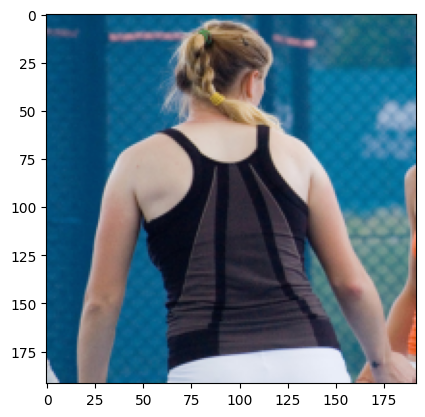

In [95]:
plt.imshow(vqa_batch["image"][0].permute(1, 2, 0))

In [96]:
question

['What is the hairstyle of the blond called?']

In [97]:
model.eval()

batch = {
    "question": question,
    "image": image,
    "answer": [""],
}
i = 0
token = ""
with torch.no_grad():
    while i < 10 and token != _text_tokenizer.eos_token:
        x, y, m = sequence_vqa(tokenize_text, embed_text, tokenize_image, embed_image, batch)
        x, y, m = x.to(device), y.to(device), m.to(device)
        o = model(inputs_embeds=x)
        predicted = lm_head(o.last_hidden_state)
        token = _text_tokenizer.decode(predicted.softmax(dim=2)[0].multinomial(num_samples=1).squeeze(1)[768+i])
        token = _text_tokenizer.decode(predicted.argmax(dim=2).squeeze(0)[768+i])
        # with temperature
        heat = 0.1
        heated = predicted / heat
        token = _text_tokenizer.decode(heated.softmax(dim=2)[0].multinomial(num_samples=1).squeeze()[768+i])
        batch["answer"][0] += token
        i += 1
batch["answer"]

['<|endoftext|>']

Ok. We're not getting "ponytail". Why not? What is the log prob of those tokens? Are we moving in the right direction? Will we get there eventually?

### What 10 next-words does the model assign highest probability to?

In [98]:
batch = {
    "question": question,
    "image": image,
    "answer": [""],
}
i = 0
token = ""

In [99]:
x, y, m = sequence_vqa(tokenize_text, embed_text, tokenize_image, embed_image, batch)
x, y, m = x.to(device), y.to(device), m.to(device)

In [100]:
o = model(inputs_embeds=x)

In [101]:
predicted = lm_head(o.last_hidden_state)

In [102]:
predicted.shape

torch.Size([1, 1024, 50257])

In [103]:
predicted[0][-1][:5]

tensor([ 2.4456, -2.5555, -2.3954, -2.5900, -2.9832], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [104]:
" | ".join(_text_tokenizer.decode(p) for p in predicted[0][768].topk(20).indices.tolist())

'<|endoftext|> | \n |  the | What | , |  it | ? |  you |  in | the | I |  is |  to | . |  a |  this | First |  o | Is |  though'

In [105]:
i = 10
bos_token = eos_token = _text_tokenizer.bos_token
model.train()
for epoch in tqdm(range(i)):
    try:
        text_xs, text_ys, text_mask = next(text_dataloader_iter)
    except StopIteration:
        text_dataloader_iter = iter(fresh_text_dataloader())
        text_xs, text_ys, text_mask = next(text_dataloader_iter)
    try:
        vqa_xs, vqa_ys, vqa_mask = next(vqa_dataloader_iter)
    except StopIteration:
        vqa_dataloader_iter = iter(fresh_vqa_dataloader())
        vqa_xs, vqa_ys, vqa_mask = next(vqa_dataloader_iter)
    x = torch.concat([text_xs, vqa_xs]).to(device)
    y = torch.concat([text_ys, vqa_ys]).to(device)
    m = torch.concat([text_mask, vqa_mask]).to(device)
    # x = vqa_xs.to(device)
    # y = vqa_ys.to(device).to(torch.long)
    # m = vqa_mask.to(device)    
    optimizer.zero_grad()
    o = model(inputs_embeds=x)
    p = lm_head(o.last_hidden_state)
    loss = cross_entropy(p, y, m)
    loss.backward()
    optimizer.step()

    if epoch % 50 == 0:
        print(f"Epoch [{epoch}/{i}], Loss: {loss.item()}")
print(f"Epoch [{epoch}/{i}], Loss: {loss.item()}")        

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [0/10], Loss: 5.442127227783203
Epoch [9/10], Loss: 5.043913841247559


# Control

Notes:

- Even though we're using reinforcement learning datasets, this isn't reinforcement learning.
  - We never care about rewards.
  - Our samples are from expert players. We just learn to mimic them.
- I'm turning grid observations into images.
  - More image training data.

In [106]:
import minari

minigrid_dataset = minari.load_dataset('D4RL/minigrid/fourrooms-v0', download=True)
env  = minigrid_dataset.recover_environment()

In [107]:
print("Observation space:", minigrid_dataset.observation_space)
print("Action space:", minigrid_dataset.action_space)
print("Total episodes:", minigrid_dataset.total_episodes)
print("Total steps:", minigrid_dataset.total_steps)

Observation space: Dict('direction': Discrete(4), 'image': Box(0, 255, (7, 7, 3), uint8), 'mission': Text(1, 14, charset=                                                              ''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''(),,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdeeeffghijklmnnoopqrrssttuvwxyzz{}))
Action space: Discrete(7)
Total episodes: 590
Total steps: 10010


In [108]:
minigrid_dataset.set_seed(seed=123)

for i in range(5):
    # sample 5 episodes from the dataset
    episodes = minigrid_dataset.sample_episodes(n_episodes=5)
    # get id's from the sampled episodes
    ids = list(map(lambda ep: ep.id, episodes))
    print(f"EPISODE ID'S SAMPLE {i}: {ids}")

EPISODE ID'S SAMPLE 0: [31, 348, 9, 536, 400]
EPISODE ID'S SAMPLE 1: [103, 265, 544, 204, 477]
EPISODE ID'S SAMPLE 2: [302, 158, 14, 505, 522]
EPISODE ID'S SAMPLE 3: [240, 125, 371, 87, 435]
EPISODE ID'S SAMPLE 4: [468, 125, 305, 489, 469]


In [109]:
episodes[0].observations["direction"]

array([0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3])

In [110]:
episode = episodes[0]

In [111]:
from minigrid.wrappers import RGBImgObsWrapper

In [112]:
episode.actions

array([2, 2, 2, 2, 2, 2, 0, 2, 2, 2])

In [113]:
from minigrid.core import constants as mgc

In [114]:
def minigrid_to_rgb(obs):
    _obs = torch.zeros(obs.shape, dtype=torch.uint8)
    for i in range(_obs.size(0)):
        for j in range(_obs.size(1)):
            _obs[i, j] = torch.from_numpy(mgc.COLORS[mgc.IDX_TO_COLOR[obs[i, j, 1]]]).to(torch.uint8)
    return _obs.permute(2, 0, 1)

In [115]:
obs = episode.observations["image"][0]
obs.shape

(7, 7, 3)

In [116]:
mgc.IDX_TO_COLOR
obs[1]

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0]], dtype=uint8)

In [117]:
minigrid_to_rgb(episode.observations["image"][5])

tensor([[[255, 255, 255, 255, 100,   0, 255],
         [255, 255, 255, 255, 100, 255, 255],
         [255, 255, 255, 255, 100, 255, 255],
         [255, 255, 255, 255, 100, 255, 255],
         [255, 255, 255, 255, 100, 255, 255],
         [255, 255, 255, 255, 100, 255, 255],
         [255, 255, 255, 255, 100, 255, 255]],

        [[  0,   0,   0,   0, 100, 255,   0],
         [  0,   0,   0,   0, 100,   0,   0],
         [  0,   0,   0,   0, 100,   0,   0],
         [  0,   0,   0,   0, 100,   0,   0],
         [  0,   0,   0,   0, 100,   0,   0],
         [  0,   0,   0,   0, 100,   0,   0],
         [  0,   0,   0,   0, 100,   0,   0]],

        [[  0,   0,   0,   0, 100,   0,   0],
         [  0,   0,   0,   0, 100,   0,   0],
         [  0,   0,   0,   0, 100,   0,   0],
         [  0,   0,   0,   0, 100,   0,   0],
         [  0,   0,   0,   0, 100,   0,   0],
         [  0,   0,   0,   0, 100,   0,   0],
         [  0,   0,   0,   0, 100,   0,   0]]], dtype=torch.uint8)

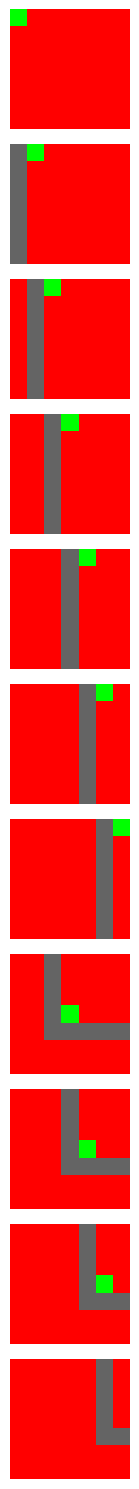

In [118]:
l = episode.observations["image"].shape[0]
fig, axs = plt.subplots(l, 1, figsize=(15, 15))
for i in range(l):
    axs[i].imshow(minigrid_to_rgb(episode.observations["image"][i]).permute(1, 2, 0))
    axs[i].axis("off")
plt.tight_layout()
plt.show()

In [119]:
image_resize = transforms.RandomResizedCrop((192, 192), (0.5, 1.0))

In [120]:
minigrid_to_rgb(episode.observations["image"][5]).shape

torch.Size([3, 7, 7])

In [121]:
resized_minari_grid_observation_image = image_resize([minigrid_to_rgb(episode.observations["image"][1])])
resized_minari_grid_observation_image[0].shape

torch.Size([3, 192, 192])

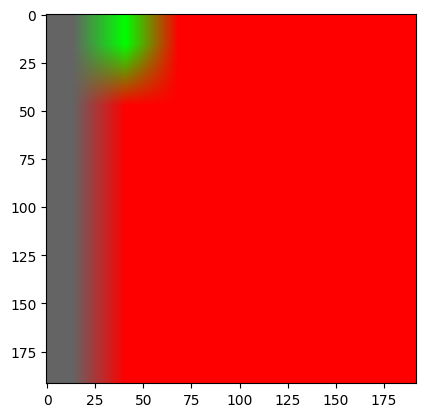

In [122]:
plt.imshow(image_resize([minigrid_to_rgb(episode.observations["image"][1])])[0].permute(1, 2, 0))

In [123]:
episodes[0]

EpisodeData(id=468, total_steps=10, observations={direction: ndarray of shape (11,) and dtype int64, image: ndarray of shape (11, 7, 7, 3) and dtype uint8, mission: ['reach the goal', 'reach the goal', 'reach the goal', 'reach the goal', 'reach the goal', 'reach the goal', 'reach the goal', 'reach the goal', 'reach the goal', 'reach the goal', 'reach the goal']}, actions=ndarray of shape (10,) and dtype int64, rewards=ndarray of 10 floats, terminations=ndarray of 10 bools, truncations=ndarray of 10 bools, infos=dict with the following keys: [])

### How many timesteps fit in a sequence length?

See § 2, Gato randomly samples subsequences of L tokens.

This is tough. MiniGrid is _like_ an image. But it's not. Do we treat it like an image as far as tokenization goes? It's 7x7x3. We're looking at 147 tokens if we treat them as discrete values. That's not too far below the number of tokens a 16x16 bunch of patches uses.

I say we treat it like an image. That means we'll need to upscale it.

### Would CartPole be a better example dataset?

In [125]:
_discrete_embedding = nn.Embedding(1024, HIDDEN_DIMS)
embed_discrete = _discrete_embedding

In [132]:
batch = minigrid_dataset.sample_episodes(4)

In [239]:
separator_token = tokenize_text("|", return_tensors="pt")["input_ids"]
separator_token

tensor([[91]])

In [244]:
separator_embedding = embed_text(separator_token)
separator_embedding.shape

torch.Size([1, 1, 432])

In [232]:
# Sequence each sample from the batch individually
#   Take random subsequence if the result is greater than context length
#   Pad/mask if it's less than context length
# torch.stack them into a batch.
# return the batch (xs), the action (ys), and the mask

# Text embeddings
text_tokens = tokenize_text(batch[0].observations["mission"], padding="longest", return_tensors="pt")
text_embeddings = embed_text(text_tokens["input_ids"])

# Visual embeddings
minigrid_images = [minigrid_to_rgb(image) for image in batch[0].observations["image"]]
minigrid_images_resized = [image_resize(image) for image in minigrid_images]
image_tokens = tokenize_image(minigrid_images_resized)
# batch[0].observation["image"] is in numpy format, HxWxC.
# heights, widths = map(torch.tensor, zip(*[image.shape[1:3] for image in batch[0].observations["image"]]))
heights, widths = map(torch.tensor, zip(*[image.shape[1:3] for image in minigrid_images_resized]))
n_patch_rows, n_patch_cols = n_patch_rows_cols(12, 12, heights, widths)
image_embeddings = embed_image(n_patch_rows, n_patch_cols, image_tokens)


# Discrete embeddings
discrete_embeddings = embed_discrete(torch.from_numpy(batch[0].observations["direction"])).unsqueeze(dim=1)

# Separator_embedding
# defined above

# Action embeddings
action_embeddings = embed_discrete(torch.from_numpy(batch[0].actions)).unsqueeze(dim=1)

text_embeddings.shape, image_embeddings.shape, discrete_embeddings.shape, action_embeddings.shape

(torch.Size([7, 3, 432]),
 torch.Size([7, 256, 432]),
 torch.Size([7, 1, 432]),
 torch.Size([6, 1, 432]))

### How do we combine the control embeddings into a sequence?

In [268]:
# Interleaving tensors
sequence = []
for i in range(action_embeddings.size(0)):
    sequence.append(torch.concat([text_embeddings[i], image_embeddings[i], discrete_embeddings[i], separator_embedding[0], action_embeddings[i]]))
sequence.append(torch.concat([text_embeddings[-1], image_embeddings[-1], discrete_embeddings[-1]]))
sequence = torch.concat(sequence)
sequence.shape

torch.Size([1832, 432])

### Wrapping that all up into a function

In [277]:
def sequence_control(tokenize_text, embed_text, tokenize_image, embed_image, embed_discrete, separator_embedding, batch):
    sequenced_batch = []
    for sample in batch:
        # Text embeddings
        text_tokens = tokenize_text(batch[0].observations["mission"], padding="longest", return_tensors="pt")
        text_embeddings = embed_text(text_tokens["input_ids"])
        
        # Visual embeddings
        minigrid_images = [minigrid_to_rgb(image) for image in batch[0].observations["image"]]
        minigrid_images_resized = [image_resize(image) for image in minigrid_images]
        image_tokens = tokenize_image(minigrid_images_resized)
        # batch[0].observation["image"] is in numpy format, HxWxC.
        # heights, widths = map(torch.tensor, zip(*[image.shape[1:3] for image in batch[0].observations["image"]]))
        heights, widths = map(torch.tensor, zip(*[image.shape[1:3] for image in minigrid_images_resized]))
        n_patch_rows, n_patch_cols = n_patch_rows_cols(12, 12, heights, widths)
        image_embeddings = embed_image(n_patch_rows, n_patch_cols, image_tokens)
        
        
        # Discrete embeddings
        discrete_embeddings = embed_discrete(torch.from_numpy(batch[0].observations["direction"])).unsqueeze(dim=1)
        
        # Separator_embedding
        # defined above
        
        # Action embeddings
        action_embeddings = embed_discrete(torch.from_numpy(batch[0].actions)).unsqueeze(dim=1)

        sequence = []
        for i in range(action_embeddings.size(0)):
            sequence.append(torch.concat([text_embeddings[i], image_embeddings[i], discrete_embeddings[i], separator_embedding[0], action_embeddings[i]]))
        sequence.append(torch.concat([text_embeddings[-1], image_embeddings[-1], discrete_embeddings[-1]]))
        sequence = torch.concat(sequence)

        if len(sequence) > SEQUENCE_LENGTH:
            offset = random.randint(0, len(sequence) - int(SEQUENCE_LENGTH // 2)) # / 2 to try to get final action more often than 1/SEQUENCE_LENGTH
            sequence = sequence[offset:offset+SEQUENCE_LENGTH]
            control_mask = torch.ones(SEQUENCE_LENGTH)
        if len(sequence) < SEQUENCE_LENGTH:  # Can't be else, might shorten sequence in above if
            padding = torch.zeros((SEQUENCE_LENGTH - len(sequence), *sequence.shape[1:]))
            sequence = torch.concat([sequence, padding])
            control_mask = torch.zeros((SEQUENCE_LENGTH)) + torch.ones(SEQUENCE_LENGTH)
   
        sequenced_batch.append(sequence)
    return torch.stack(sequenced_batch)

In [278]:
sequenced_batch = sequence_control(
    tokenize_text,
    embed_text,
    tokenize_image,
    embed_image,
    embed_discrete,
    separator_embedding,
    batch
)

In [279]:
sequenced_batch.shape

torch.Size([4, 1024, 432])

### TODO: Do we need to mask out images here, like we do in visual question answering data?

### If sequence > sequence length, sample random subsequence

In [269]:
sequence = sequence[:-10]

In [270]:
if len(sequence) > SEQUENCE_LENGTH:
    offset = random.randint(0, len(sequence) - int(SEQUENCE_LENGTH // 2)) # / 2 to try to get final action more often than 1/SEQUENCE_LENGTH
    sequence = sequence[offset:offset+SEQUENCE_LENGTH]
    control_mask = torch.ones(SEQUENCE_LENGTH)
if len(sequence) < SEQUENCE_LENGTH:  # Can't be else, might shorten sequence in above if
    padding = torch.zeros((SEQUENCE_LENGTH - len(sequence), *sequence.shape[1:]))
    sequence = torch.concat([sequence, padding])
    control_mask = torch.zeros((SEQUENCE_LENGTH)) + torch.ones(SEQUENCE_LENGTH)
sequence.shape, control_mask.shape

(torch.Size([1024, 432]), torch.Size([1024]))

In [127]:
separator = tokenize_text("|")["input_ids"]
def minigrid_collate_fn(tokenize_text, embed_text, tokenize_image, embed_image, embed_discrete, batch):
    """For when the dataset is doing the batching."""
    result = torch.ones((SEQUENCE_LENGTH, batch.size(0))) * -1
    text_embeddings = embed_text(tokenize_text(batch["mission"]))
    image_embeddings = embed_image(tokenize_image([image_resize(minigrid_to_rgb(i)) for i in episode.observations["image"]]))
    separators = embed_text([separator] * len(episode.actions))
    action_tokens = embed_discrete(episode.actions)
    return 

In [128]:
tokenize_text(episode.observations["mission"], padding="longest", truncation=True, return_tensors="pt")["input_ids"].shape

torch.Size([11, 3])

# TODO: Pickup from here.

You're trying to sequence a MiniGrid dataset. You'll need the batch to have an attention mask if the sequence doesn't fill the context window. And you'll want to randomly sample a subsequence if the sequence overflows the context window.

In [129]:
text_embeddings = embed_text(tokenize_text(episode.observations["mission"])["input_ids"])

TypeError: embedding(): argument 'indices' (position 2) must be Tensor, not list

In [ ]:
separator

In [ ]:
text_tokens = tokenize_text(episode.observations["mission"][i])["input_ids"]
text_tokens

In [130]:
image = image_resize(minigrid_to_rgb(episode.observations["image"][i]))
image_tokens = tokenize_image([image])
image_tokens.shape

torch.Size([1, 256, 432])

In [131]:
sequence = []
sequence.extend(text_tokens)
sequence.extend(image_tokens)
sequence.extend(separator)
sequence

NameError: name 'text_tokens' is not defined

In [ ]:
minigrid_collate_fn(minigrid_dataset.sample_episodes(2))

In [ ]:
resized_minari_grid_observation_image[0].shape

In [ ]:
tokenize_image(resized_minari_grid_observation_image).shape

In [ ]:
minigrid_dataloader = DataLoader(minigrid_dataset, collate_fn=minigrid_collate_fn)

In [ ]:
next(iter(minigrid_dataloader))

In [ ]:
ed = minigrid_dataset.sample_episodes(2)[0]

In [ ]:
dir(ed)